In [1]:
import numpy as np
import pandas as pd
import scipy
import scipy.linalg
import matplotlib.pyplot as plt
import sklearn.metrics
import sklearn.neighbors
import time

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, TensorDataset

import ipdb

import bda_utils

In [2]:
bda_utils.setup_seed(10)

## 1.b. Load Data

In [3]:
Xs, Xt = bda_utils.load_data(if_weekday=1, if_interdet=1)
Xs = Xs[:, :1]
Xt = Xt[:, :1]
Xs, Xs_min, Xs_max = bda_utils.normalize2D(Xs)
Xt, Xt_min, Xt_max = bda_utils.normalize2D(Xt)

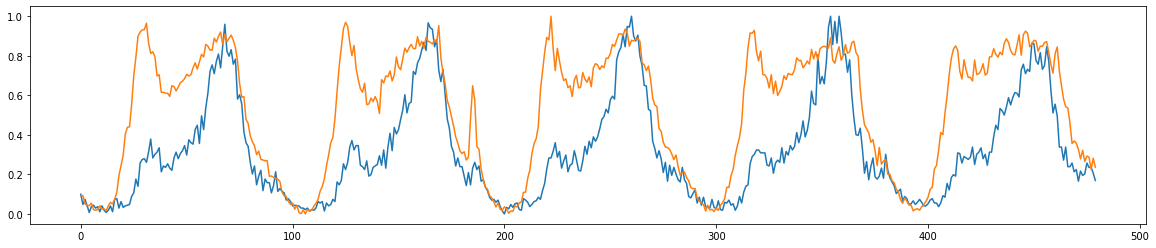

In [4]:
for i in range(Xs.shape[1]):
    plt.figure(figsize=[20,4])
    plt.plot(Xs[:, i])
    plt.plot(Xt[:, i])

## 1.d. Hyperparameters

In [5]:
label_seq_len = 3
# batch_size = full batch
seq_len = 12
reduced_dim = 4
inp_dim = min(Xs.shape[1], Xt.shape[1])
label_dim = min(Xs.shape[1], Xt.shape[1])
hid_dim = 12
layers = 1
lamb = 3

hyper = {
    'inp_dim':inp_dim,
    'label_dim':label_dim,
    'label_seq_len':label_seq_len,
    'seq_len':seq_len,
    'reduced_dim':reduced_dim,
    'hid_dim':hid_dim,
    'layers':layers,
    'lamb':lamb}
hyper = pd.DataFrame(hyper, index=['Values'])

In [6]:
hyper

,inp_dim,label_dim,label_seq_len,seq_len,reduced_dim,hid_dim,layers,lamb
Values,1,1,3,12,4,12,1,3


## 1.e. Apply BDA and get $Xs_{new}$, $Xt_{new}$ 

In [7]:
Xs = Xs[:96, :]

In [8]:
# [sample size, seq_len, inp_dim (dets)], [sample size, label_seq_len, inp_dim (dets)]
Xs_3d, Ys_3d = bda_utils.sliding_window(Xs, Xs, seq_len, 1)  
Xt_3d, Yt_3d = bda_utils.sliding_window(Xt, Xt, seq_len, 1)
print(Xs_3d.shape)
print(Ys_3d.shape)
print(Xt_3d.shape)
print(Yt_3d.shape)

(84, 12, 1)
(84, 1, 1)
(468, 12, 1)
(468, 1, 1)


In [9]:
t_s = time.time()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Xs_train_3d = []
Ys_train_3d = []
Xt_valid_3d = []
Xt_train_3d = []
Yt_valid_3d = []
Yt_train_3d = []

for i in range(Xs_3d.shape[2]):
    print('Starting det %i'%i)
#     bda = BDA(kernel_type='linear', dim=seq_len-reduced_dim, lamb=lamb, mu=0.6, gamma=1, T=1)  # T is iteration time
#     Xs_new, Xt_new, A = bda.fit(
#         Xs_3d[:, :, i], bda_utils.get_class(Ys_3d[:, :, i]), Xt_3d[:, :, i], bda_utils.get_class(Yt_3d[:, :, i])
#     )  # input shape: ns, n_feature | ns, n_label_feature
    Xs_new = Xs_3d[:, :, 0]
    Xt_new = Xt_3d[:, :, 0]
    
    print(Xs_new.shape)
    print(Xt_new.shape)

    day_train_t = 1
    Xs_train = Xs_new.copy()
    Ys_train = Ys_3d[:, :, i]
    Xt_valid = Xt_new.copy()[int(96):, :]
    Xt_train = Xt_new.copy()[:int(96), :]
    Yt_valid = Yt_3d[:, :, i].copy()[int(96):, :]
    Yt_train = Yt_3d[:, :, i].copy()[:int(96), :]
    
    Xs_train_3d.append(Xs_train)
    Ys_train_3d.append(Ys_train)
    Xt_valid_3d.append(Xt_valid)
    Xt_train_3d.append(Xt_train)
    Yt_valid_3d.append(Yt_valid)
    Yt_train_3d.append(Yt_train)


Xs_train_3d = np.array(Xs_train_3d)
Ys_train_3d = np.array(Ys_train_3d)
Xt_valid_3d = np.array(Xt_valid_3d)
Xt_train_3d = np.array(Xt_train_3d)
Yt_valid_3d = np.array(Yt_valid_3d)
Yt_train_3d = np.array(Yt_train_3d)

# bda_utils.save_np(Xs_train_3d, './outputs/BDA/Xs_new_%i.csv'%(bda_utils.get_num()-14/6))
# bda_utils.save_np(Ys_train_3d, './outputs/BDA/Xt_new_%i.csv'%(bda_utils.get_num()-14/6))
# bda_utils.save_np(Xt_valid_3d, './outputs/BDA/Xs_new_%i.csv'%(bda_utils.get_num()-14/6))
# bda_utils.save_np(Xt_train_3d, './outputs/BDA/Xt_new_%i.csv'%(bda_utils.get_num()-14/6))
# bda_utils.save_np(Yt_valid_3d, './outputs/BDA/Xs_new_%i.csv'%(bda_utils.get_num()-14/6))
# bda_utils.save_np(Yt_train_3d, './outputs/BDA/Xt_new_%i.csv'%(bda_utils.get_num()-14/6))

print('Time spent:%.5f'%(time.time()-t_s))

Starting det 0
(84, 12)
(468, 12)
Time spent:0.03678


In [10]:
Xs_train_3d = np.transpose(Xs_train_3d, (1, 2, 0))
Ys_train_3d = np.transpose(Ys_train_3d, (1, 2, 0))
Xt_valid_3d = np.transpose(Xt_valid_3d, (1, 2, 0))
Xt_train_3d = np.transpose(Xt_train_3d, (1, 2, 0))
Yt_valid_3d = np.transpose(Yt_valid_3d, (1, 2, 0))
Yt_train_3d = np.transpose(Yt_train_3d, (1, 2, 0))

In [11]:
Xs_train_3d.shape

(84, 12, 1)

# 2. Learning Part

## 2.a. Build network

In [12]:
from bda_utils import traff_net_reg

## 2.b. Assemble Dataloader

In [13]:
batch_size = 1960

train_x = np.vstack([Xs_train_3d, Xt_train_3d])
train_y = np.vstack([Ys_train_3d, Yt_train_3d])

train_x = torch.tensor(train_x, dtype=torch.float32).to(device)
train_y = torch.tensor(train_y, dtype=torch.float32).to(device)
Xt_valid_3d = torch.tensor(Xt_valid_3d, dtype=torch.float32).to(device)
Yt_valid_3d = torch.tensor(Yt_valid_3d, dtype=torch.float32).to(device)

train_dataset = TensorDataset(train_x, train_y)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size, shuffle=False)
train_iter = iter(train_loader)

print(train_x.shape)
print(train_y.shape)
print('\n')
print(Xt_valid_3d.shape)
print(Yt_valid_3d.shape)

torch.Size([180, 12, 1])
torch.Size([180, 1, 1])


torch.Size([372, 12, 1])
torch.Size([372, 1, 1])


## 2.c. Learn

In [14]:
# build model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = traff_net_reg(1, label_dim, seq_len).to(device)
criterion = nn.MSELoss()
#scheduler =  torch.optim.lr_scheduler.StepLR(optimizer, 0.7)
train_loss_set = []
val_loss_set = []

det = 0  # which detector to visualize

In [15]:
optimizer = torch.optim.Adam(net.parameters())

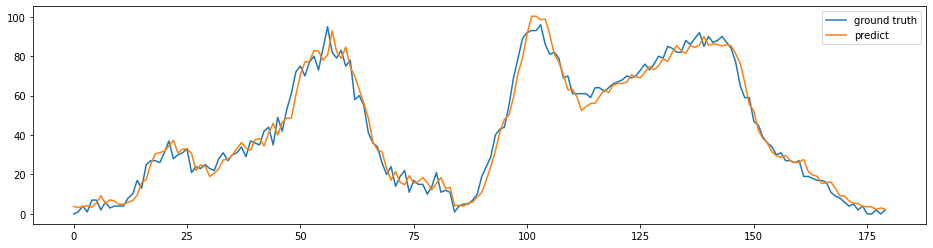

Epoch No. 0 success, loss: 24.99306, val loss: 39.92737


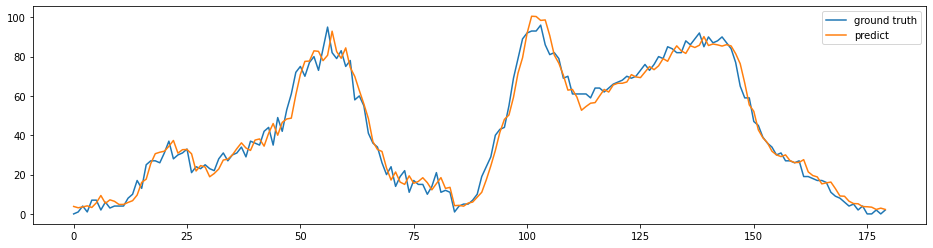

Epoch No. 50 success, loss: 24.47231, val loss: 39.16512


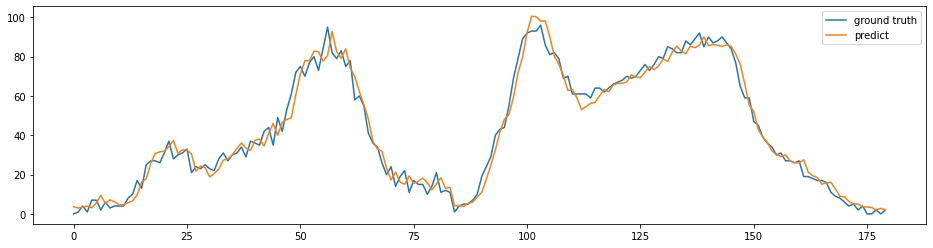

Epoch No. 100 success, loss: 24.01281, val loss: 38.58774


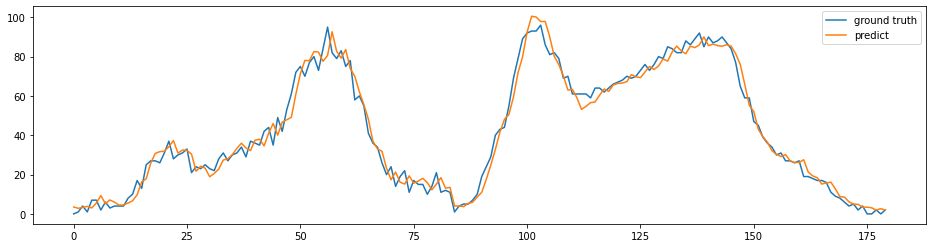

Epoch No. 150 success, loss: 23.62023, val loss: 37.91589


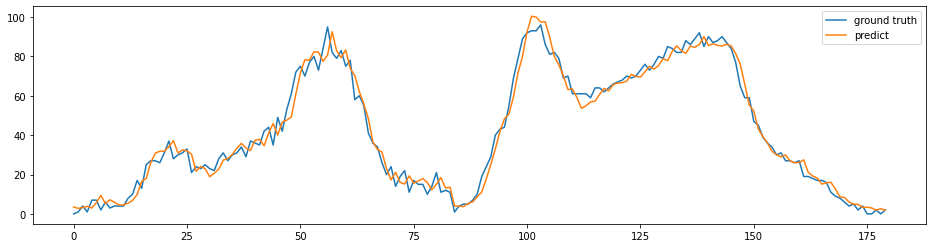

Epoch No. 200 success, loss: 23.23490, val loss: 37.23162


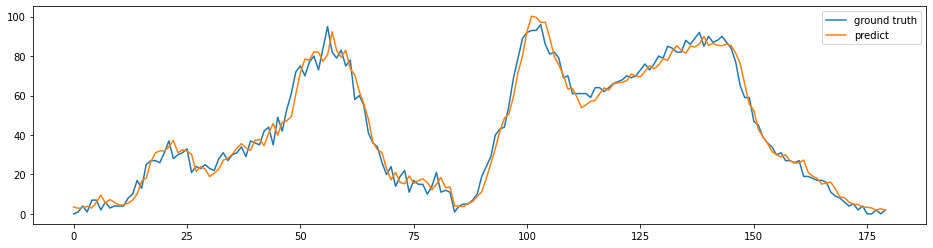

Epoch No. 250 success, loss: 22.83345, val loss: 36.64064


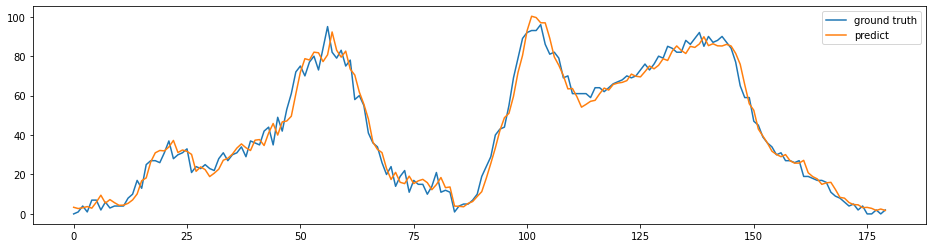

Epoch No. 300 success, loss: 22.48283, val loss: 36.24720


In [24]:
# train
net.train()

epochs = 301

for e in range(epochs):
    for i in range(len(train_loader)):
        try:
            data, label = train_iter.next()
        except:
            train_iter = iter(train_loader)
            data, label = train_iter.next()
#         ipdb.set_trace()
        out = net(data)
        loss = criterion(out*100, bda_utils.get_class(label[:, 0, 0]).reshape(-1, 1) )  # label.shape=[batch, 1, num_dets]
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        val_out = net(Xt_valid_3d)
        val_loss = criterion(val_out*100, bda_utils.get_class(Yt_valid_3d[:, 0, 0]).reshape(-1, 1) )
        
        val_loss_set.append(val_loss.cpu().detach().numpy())
        train_loss_set.append(loss.cpu().detach().numpy())
        
    if e%50==0:
#         ipdb.set_trace()
        fig = plt.figure(figsize=[16,4])
        ax1 = fig.add_subplot(111)
        ax1.plot(bda_utils.get_class(label)[:, 0, det].cpu().detach().numpy(), label='ground truth')
        ax1.plot(100*out.cpu().detach().numpy(), label='predict')
        ax1.legend()
        plt.show()
        print('Epoch No. %i success, loss: %.5f, val loss: %.5f'\
              %(e, loss.cpu().detach().numpy(), val_loss.cpu().detach().numpy() ))

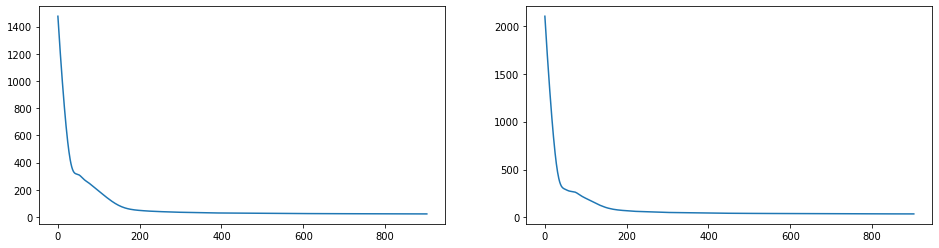

In [25]:
fig = plt.figure(figsize = [16, 4])
ax1 = fig.add_subplot(121)
ax1.plot(train_loss_set)
ax2 = fig.add_subplot(122)
ax2.plot(val_loss_set)

# 3. Evaluation

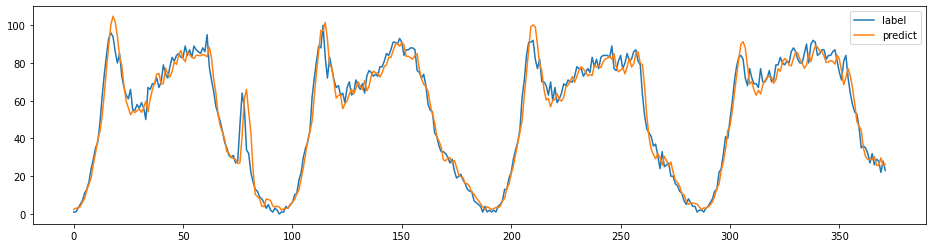

In [26]:
val_out = net(Xt_valid_3d)
plt.figure(figsize=[16,4])
plt.plot(bda_utils.get_class(Yt_valid_3d[:, 0, det]).cpu().flatten(), label='label')
plt.plot(100*val_out.cpu().detach().numpy(), label='predict')
plt.legend()

In [27]:
# sklearn.metrics.accuracy_score(torch.argmax(val_out, dim=1).cpu(), bda_utils.get_class(Yt_valid_3d[:, 0, det]).cpu().flatten())
g_t = Yt_valid_3d[:, 0, det].cpu().flatten().detach().numpy()
pred = val_out.cpu().detach().numpy().flatten()

print(bda_utils.nrmse_loss_func(pred, g_t, 0))
print(bda_utils.mape_loss_func(pred, g_t, 0))


0.061006873058605186
0.17254688


In [22]:
bda_utils.save_np(pred, './outputs/BDA/base_regression_st_pred_result.csv')
bda_utils.save_np(g_t, './outputs/BDA/base_regression_st_g_t.csv')

In [21]:
# torch.save(net.state_dict(), './model/bda_weekday_M1_M4_nrmse=%.5f.pth'%nrmse_loss)